In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoFeatureExtractor
import pandas as pd
import IPython
import torch
import dill
import librosa

/usr/local/jupyter/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2025-03-18 07:36:11.677164: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 07:36:11.723857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

Using GPU: NVIDIA GeForce RTX 2080 Ti


# Whisper

In [ ]:
# Load model & Feature Extractor
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
model_ft = WhisperForConditionalGeneration.from_pretrained("/project/thesis/model/base-ft")

processor = WhisperProcessor.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id

In [5]:
for m in [model, model_ft]:
    m.generation_config.language = "english"
    m.generation_config.task = "transcribe"
    m.generation_config.is_multilingual = False
    m.generation_config.forced_decoder_ids = None

## Merging

In [ ]:
def merge_avg(file_name, tavg_or_favg, blocks):
    file_names = []
    if blocks:
        for block in ["B1", "B2"]:
            file_names.append(f'/{tavg_or_favg}/{file_name}_{block}.pkl')

    data = []
    for name in file_names:
        
        with open(name, 'rb') as inp:
            try:
                while True:  # load all subsets of the file
                    data.append(dill.load(inp))
            except EOFError:
                pass

    # merge all subsets together -> return
    merged = [[], [], [], [], [], [], []]
    for subset in data:
        for i, layer in enumerate(subset):
            try:
                if np.array(subset).shape[-1] == 0:  # no B1 in this subset
                    continue
            except ValueError:
                pass
            merged[i].append(layer)

    for i, layer in enumerate(merged):
        merged[i] = np.concatenate(layer)

    with open(f'/{tavg_or_favg}/{file_name}_B1B2.pkl', 'wb') as outp:
        dill.dump(np.array(merged), outp)


In [152]:
sevs = ["v_l","l","m","h","all","c"]

for sev in sevs:
    print(sev)
    file_name = f"final_{sev}_pt"
    merge_avg(file_name, "tavg", True)
    file_name = f"final_{sev}_ft"
    merge_avg(file_name, "tavg", True)

v_l
l
m
h
all
c


# Datasets & Preprocessing

Data has to be normalized by the feature extractor, leading and trailing silence has been removed in preprocessing.
Whisper expects input of length 3000 (30 secs), therefore, it is padded to 30 secs by feature extractor.

In [6]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [10]:
def ds_audio_len(ds,sr,ua,threshold):
    avg_len = 0
    for i,item in enumerate(ds):
        if ua:
            duration = librosa.get_duration(y=item["audio"]["array"], sr=sr)
            avg_len += duration
        else:
            duration = librosa.get_duration(y=np.array(item), sr=sr)
            avg_len += duration
        if threshold and  duration >= threshold:
            print(i, ",", duration)
    avg_len /= len(ds)
    
    return avg_len

In [11]:
#https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers#51050772
def outlier_aware_hist(data, xlabel, ylabel, lower=None, upper=None):
    if not lower or lower < data.min():
        lower = data.min()
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > data.max():
        upper = data.max()
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto')

    if lower_outliers:
        n_lower_outliers = (data < lower).sum()
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(data.min(), lower))

    if upper_outliers:
        n_upper_outliers = (data > upper).sum()
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, data.max()))

    if lower_outliers or upper_outliers:
        plt.legend()
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [12]:
# data = [np.array1, np.array2,...]
def outlier_aware_hist_multi(data, xlabel, ylabel, title, legend, bins, stacked, alpha=1, lower=None, upper=None):
    plt.figure(figsize=(12,8))
    if not lower or lower < data[0].min():
        lower = data[0].min()
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > data[0].max():
        upper = data[0].max()
        upper_outliers = False
    else:
        upper_outliers = True

    for i,item in enumerate(data):
        n, bins, patches = plt.hist(item, range=(lower, upper), bins=bins, alpha=alpha, histtype="bar", stacked=stacked) #weights=np.ones_like(item)/item.size

        if lower_outliers:
            n_lower_outliers = (item < lower).sum()
            patches[0].set_height(patches[0].get_height() + n_lower_outliers)
            #patches[0].set_facecolor('c')
            patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(item.min(), lower))

        if upper_outliers:
            n_upper_outliers = (item > upper).sum()
            patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
            #patches[-1].set_facecolor('m')
            patches[-1].set_label('Upper outliers {}: ({:.2f}, {:.2f})'.format(legend[i],upper, item.max()))

    if lower_outliers or upper_outliers:
        plt.legend(fontsize=15)
    
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=15)
    plt.show()

In [ ]:
ds_crayon = load_pkl('/datasets/crayon_merged.pkl')
ds_severities_merged = load_pkl('/datasets/severities_merged.pkl')
ds_severities = load_pkl('/datasets/severities.pkl')
ds_M2 = load_pkl('/datasets/severities_M2.pkl')
ds_M3 = load_pkl('/datasets/severities_M3.pkl')
ds_M4 = load_pkl('/datasets/severities_M4.pkl')
ds_M5 = load_pkl('/datasets/severities_M5.pkl')
ds_M6 = load_pkl('/datasets/severities_M6.pkl')
ds_M7 = load_pkl('/datasets/severities_M7.pkl')
ds_M8 = load_pkl('/datasets/severities_M8.pkl')
ds_test = load_pkl('/datasets/severities_merged_test.pkl')
ds_final = load_pkl('/datasets/final.pkl')

## Dataset Statistics

- Speakers: 19 speakers with Cerebral Palsy
- Age-matched and gender-matched controls
- 765 isolated words per speaker
- 300 distinct uncommon words
- Block 255 words: 155 words - 100 common words, 26 radio alphabet letters, 19 command words,  10 digits, each repeated three times, once per block
- Uncommon words repreated once, 100 uncommon words per block for a total of 300
- Recorded through an 8-microphone array and one digital video camera
    - M1 generally used for synchronization tones
	- M2-M8 generally recorded speech -> chose M5

**Number of speakers per severity**

Speakers with Cerebral Palsy: 4x F, 11x M
- ids_v_l = ["M01", "M04", "F03", "M12"]
- ids_l = ["M07", "F02", "M16"]
- ids_m =  ["M05", "F04", "M11"]
- ids_h = ["M08", "M09", "M10", "F05", "M14"]

Control speakers: 4x F, 9x M
- CF02, CF03, CF04, CF05
- CM01, CM04, CM05, CM06, CM08, CM09, CM10, CM12, CM13



-> M02, M03, F01 recorded under different protocol

-> M06 did not approve redistribution of data

In [77]:
# number of samples
print(f'number of samples - all: {len(ds_final["all"])} (not merged: {len(ds_M5["all"])})')
print(f'number of samples - v_l: {len(ds_final["v_l"])} (not merged: {len(ds_M5["v_l"])})')
print(f'number of samples - l: {len(ds_final["l"])} (not merged: {len(ds_M5["l"])})')
print(f'number of samples - m: {len(ds_final["m"])} (not merged: {len(ds_M5["m"])})')
print(f'number of samples - h: {len(ds_final["h"])} (not merged: {len(ds_M5["h"])})')
print(f'number of samples - control: {len(ds_final["c"])} (not merged: {len(ds_M5["c"])})')
print("------------------------------")

# number of words per speaker
print(f"number of words per speaker: {len(ds_final['all'])/15:.2f} (not merged: {len(ds_M5['all'])/15:.2f})")
print(f"number of words per control speaker: {len(ds_final['c'])/13:.2f} (not merged: {len(ds_M5['c'])/13:.2f})")
print("------------------------------")

# average length of samples per severity
for sev in ["v_l", "l", "m", "h", "all", "c"]:
    len_sev_final =  ds_audio_len(ds_final[sev], 16000, False, False)
    len_sev =  ds_audio_len(ds_M5[sev], 16000, False, False)
    print(f"Average length of samples - {sev}: {len_sev_final:.2f} seconds (not merged: {len_sev:.2f} seconds)")
    

number of samples - all: 11220 (not merged: 11436)
number of samples - v_l: 2896 (not merged: 3036)
number of samples - l: 2261 (not merged: 2295)
number of samples - m: 2251 (not merged: 2280)
number of samples - h: 3812 (not merged: 3825)
number of samples - control: 9942 (not merged: 9945)
------------------------------
number of words per speaker: 748.00 (not merged: 762.40)
number of words per control speaker: 764.77 (not merged: 765.00)
------------------------------
Average length of samples - v_l: 2.61 seconds (not merged: 2.66 seconds)
Average length of samples - l: 2.09 seconds (not merged: 2.04 seconds)
Average length of samples - m: 1.68 seconds (not merged: 1.69 seconds)
Average length of samples - h: 1.29 seconds (not merged: 1.25 seconds)
Average length of samples - all: 1.87 seconds (not merged: 1.87 seconds)
Average length of samples - c: 1.60 seconds (not merged: 1.61 seconds)


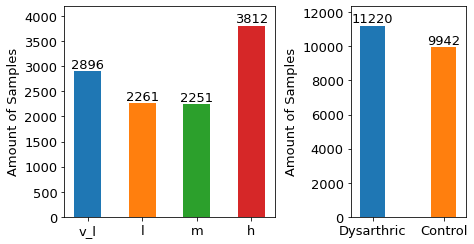

In [97]:
lengths = [len(ds_final["v_l"]),len(ds_final["l"]),len(ds_final["m"]), len(ds_final["h"])]
l_total = np.sum(np.array(lengths))
l_c = len(ds_final["c"])

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig = plt.figure()
fig.set_figwidth(480*px)
fig.set_figheight(3.5)
plt.subplot(1, 5, (1,3))
sevs = ["v_l", "l", "m", "h"]
cmap = plt.get_cmap('tab10')
ax =plt.bar(sevs, lengths, width=0.5, color=cmap.colors)
plt.bar_label(ax, label_type='edge',fontsize=13)
plt.ylabel("Amount of Samples", fontsize=13)
#plt.xlabel("Intelligibility", fontsize=13)
plt.margins(y=0.1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(1,5,(4,5), aspect="auto")
sevs = ["Dysarthric", "Control"]
ax = plt.bar(sevs, [l_total, l_c], width=0.35, color=cmap.colors)
plt.bar_label(ax, label_type='edge', fontsize=13)
plt.ylabel("Amount of Samples", fontsize=13)
#plt.xlabel("Subset", fontsize=13)
plt.margins(y=0.1)
plt.margins(x=0.1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.savefig("figs/sev_distribution.pdf")
plt.show()                                                    

-> recordings of 39 words are missing (all microphones), especially for F04 & F04. Most of them are words that are incorporated in other blocks, e.g. /F03_B3_C14_M5 but there are also UW missing like /F04_B1_UW9_M5


### Sample Lengths

In [14]:
# hist of lens
samples_final = ds_final["all"]+ds_final["c"]
samples_merged = ds_severities_merged["all"]+ds_severities_merged["c"]
samples = ds_M5["all"]+ds_M5["c"]

durations_merged = []
durations_final = []
durations = []
for sample in samples_merged:
    duration = librosa.get_duration(y=np.array(sample), sr=16000)
    durations_merged.append(duration)
    
for sample in samples:
    duration = librosa.get_duration(y=np.array(sample), sr=16000)
    durations.append(duration)

for sample in samples_final:
    duration = librosa.get_duration(y=np.array(sample), sr=16000)
    durations_final.append(duration)


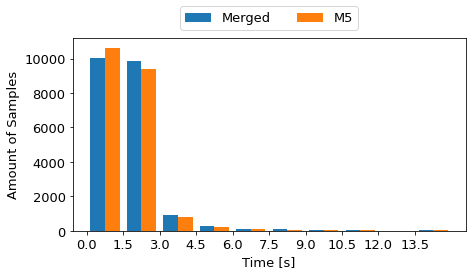

In [92]:
data = [np.array(durations_merged), np.array(durations)]
legend = ["Merged", "M5"]
test_hist_multi(data, "Time [s]", "Amount of Samples", "audio_len", legend, bins=50, stacked=False, lower=None, upper=15)

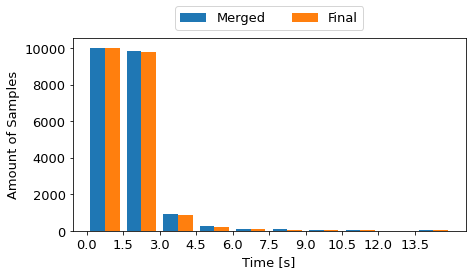

In [94]:
data = [np.array(durations_merged), np.array(durations_final)]
legend = ["Merged", "Final"]
test_hist_multi(data, "Time [s]", "Amount of Samples", "audio_len_selection", legend, bins=50, stacked=False, lower=None, upper=15)

In [39]:
longer_m = sum(i >= 10 for i in durations_merged)
longer_um = sum(i >= 10 for i in durations)
print(f"Audio samples longer than 10 seconds: merged - {longer_m}, unmerged - {longer_um} ")

Audio samples longer than 10 seconds: merged - 76, unmerged - 104 


In [24]:
# take 20 random indices
longer_10 = []
for sample in samples_merged:
    duration = librosa.get_duration(y=np.array(sample), sr=16000)
    if duration >= 10:
        longer_10.append(sample)
    
test_inds = np.random.randint(len(longer_10),size=20)

In [55]:
# check for 20 samples of the longer samples, if there is a error 
IPython.display.Audio(longer_10[test_inds[19]], rate=16000) # ->5/20 have errors
# -> there are still errors after merging microphones

### Transcription Lengths

In [99]:
# data = [np.array1, np.array2,...]
def test_hist_multi(data, xlabel, ylabel, title, legend, bins, stacked, log=False, lower=None, upper=None):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.figure().set_figwidth(480*px)
    fs=13
    if not lower or lower < data[0].min():
        lower = data[0].min()
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > data[0].max():
        upper = data[0].max()
        upper_outliers = False
    else:
        upper_outliers = True
    
    
    n, bins, patches = plt.hist(data, range=(0, upper),align="mid", alpha=1, label=legend, histtype="bar", stacked=stacked) #
    #print(bins)
    #print(n)
    #print(patches)
    for i,item in enumerate(data):
        
        #print(patches[0])
        if lower_outliers:
            n_lower_outliers = (item < lower).sum()
            patches[i].patches[0].set_height(patches[i].patches[0].get_height() + n_lower_outliers)
            #patches[0].set_facecolor('c')
            #patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(item.min(), lower))

        if upper_outliers:
            n_upper_outliers = (item > upper).sum()
            #print(n_upper_outliers)
            patches[i].patches[-1].set_height(patches[i].patches[-1].get_height() + n_upper_outliers)
            #patches[-1].set_facecolor('m')
            #patches[-1].patches[i].set_label('Upper outliers {}: ({:.2f}, {:.2f})'.format(legend[i],upper, item.max()))

    if lower_outliers or upper_outliers:
        plt.legend(fontsize=fs,loc='upper center', bbox_to_anchor=(0.5, 1.4), ncols=4)
    
    plt.xlabel(xlabel, fontsize=fs)
    plt.ylabel(ylabel, fontsize=fs)
    plt.xticks(bins[:-1],fontsize=fs)
    plt.yticks(fontsize=fs)
    if log:
        plt.yscale('log', nonpositive='clip')
    #plt.title(title, fontsize=15)
    #plt.legend(fontsize=fs, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf")
    plt.show()

In [14]:
def find_paths(inds):
    attributes = ["speakers", "block_id", "transcripts"]
    infos = {
        "speakers": [],
        "block_id": [],
        "transcripts": []
    }
    
    for attribute in attributes:
        info = ds_severities_merged[f"{attribute}_all"]+ds_severities_merged[f"{attribute}_c"]
        info = list(map(lambda i: info[i], inds))
        infos[attribute] = info 
    
    word_filename = pd.read_excel("/data/project/uafiles/doc/speaker_wordlist.xls", sheet_name="Word_filename")

    # find correct paths that have to be removed
    paths = []
    for i in range(len(inds)):
        filename = word_filename[word_filename["WORD"]==infos["transcripts"][i]]["FILE NAME"].values
        if len(filename) > 1:
            # some transcripts are used multiple times -> find correct one
            fn = [s for s in filename if infos["block_id"][i] in s]
            filename = fn[0]
        elif len(filename) == 1:
            filename = filename[0]
        else:
            print("error while searching for filename")

        # combine parts of path
        if filename.startswith("B"): # uncommon word
            path = infos["speakers"][i] + "_" + filename
        else: 
            path = infos["speakers"][i] + "_" + infos["block_id"][i] + "_" + filename

        paths.append(path)
    
    return paths

In [24]:
counts_merged = load_pkl('datasets/counts_merged_pt.pkl')
counts_M5 = load_pkl('datasets/counts_M5_pt.pkl')
counts_final = load_pkl('datasets/counts_final_pt.pkl')
for counts in [counts_merged, counts_M5, counts_final]:
    counts["word_count"] = np.array(counts["word_count"])
    counts["char_count"] = np.array(counts["char_count"])

In [73]:
print(len(counts_final["word_count"]))
print(len(counts_M5["word_count"]))
print(len(counts_merged["word_count"]))

21162
21381
21382


=> There are fewer samples recorded by microphone M2 than by M5

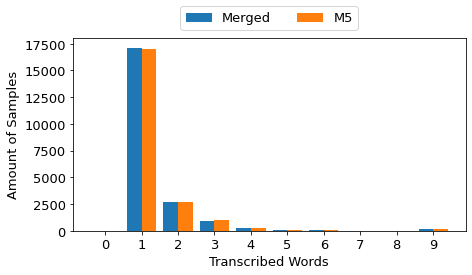

In [282]:
data = [counts_merged["word_count"], counts_M5["word_count"]]
legend = ["Merged", "M5"]
test_hist_multi(data, "Transcribed Words", "Amount of Samples", "transcript_len", legend, bins=10, stacked=False, lower=None, upper=10)

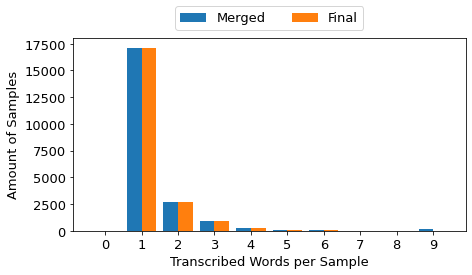

In [25]:
data = [counts_merged["word_count"], counts_final["word_count"]]
legend = ["Merged", "Final"]
test_hist_multi(data, "Transcribed Words per Sample", "Amount of Samples", "transcript_len_final", legend, bins=10, stacked=False, lower=None, upper=10)

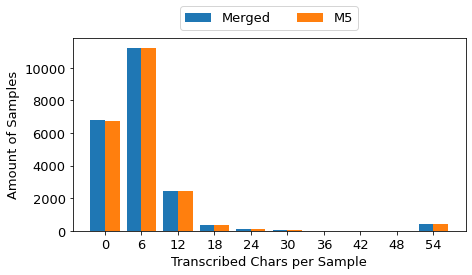

In [26]:
data = [counts_merged["char_count"], counts_M5["char_count"]]
legend = ["Merged", "M5"]
test_hist_multi(data, "Transcribed Chars per Sample", "Amount of Samples", "transcript_len_chars", legend, stacked=False,bins="auto",lower=None, upper=60)

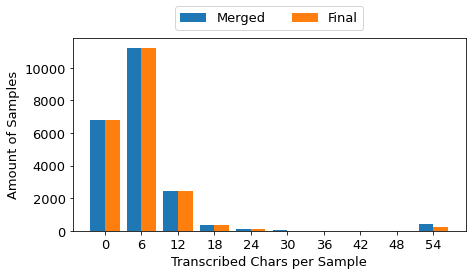

In [31]:
data = [counts_merged["char_count"], counts_final["char_count"]]
legend = ["Merged", "Final"]
test_hist_multi(data, "Transcribed Chars per Sample", "Amount of Samples", "transcript_len_chars_final", legend, stacked=False,bins="auto",lower=None, upper=60)

In [70]:
print("Maximum amount of words per sample:",np.array(counts_merged["word_count"]).max())
print("Maximum amount of chars per sample:",np.array(counts_merged["char_count"]).max())
print("Amount of samples with more than 6 transcribed words:",(np.array(counts_merged["word_count"]) > 6).sum())
print("Amount of samples with more than 100 transcribed chars:",(np.array(counts_merged["char_count"]) > 100).sum())

Maximum amount of words per sample: 6
Maximum amount of chars per sample: 1775
Amount of samples with more than 6 transcribed words: 0
Amount of samples with more than 100 transcribed chars: 227


### Performance & Examplary Predictions

In [32]:
def exemplary_preds(sevs, n_samples, ds):
    input_features = dict()
    transcripts = dict()
    targets = dict()
    all_indices = dict()

    for sev in sevs:
        print(sev)
        # take n_samples random indices
        indices = np.random.randint(len(ds_severities_merged[sev]),size=n_samples)
        all_indices[sev] = indices
        subset = [ds_severities_merged[sev][i] for i in indices]
        targets[sev] = [ds_severities_merged[f"transcripts_{sev}"][i] for i in indices]
        # calc input features for random samples
        input_features[sev] = feature_extractor(subset, sampling_rate=16000, do_normalize=True, return_tensors="pt").input_features
        # predict ids
        predicted_ids = model.generate(input_features[sev])
        # decode ids to transcripts
        transcripts[sev] =  processor.batch_decode(predicted_ids, skip_special_tokens=True)

    return transcripts, targets, all_indices

In [33]:
def wers_wersnorm_dict(metric, targets, transcripts, processor):
    #https://huggingface.co/learn/audio-course/chapter5/evaluation
    # see Radford et al. 2022 C. Text Standardisation for details on the text normalizer
    wers = dict()
    wers_norm = dict()

    for sev in sevs:
        wers[sev] = 100 * metric.compute(
            references=targets[sev], predictions=transcripts[sev]
        )

        # compute normalised WER
        all_predictions_norm = [processor.tokenizer._normalize(pred) for pred in transcripts[sev]]
        all_references_norm = [processor.tokenizer._normalize(label) for label in targets[sev]]

        wers_norm[sev] = 100 * metric.compute(
            references=all_references_norm, predictions=all_predictions_norm
        )
    
    return wers, wers_norm

In [34]:
def wers_wersnorm(metric, targets, transcripts, processor):
    #https://huggingface.co/learn/audio-course/chapter5/evaluation
    # see Radford et al. 2022 C. Text Standardisation for details on the text normalizer

    wers = 100 * metric.compute(
        references=targets, predictions=transcripts
    )

    # compute normalised WER
    all_predictions_norm = [processor.tokenizer._normalize(pred) for pred in transcripts]
    all_references_norm = [processor.tokenizer._normalize(label) for label in targets]

    wers_norm = 100 * metric.compute(
        references=all_references_norm, predictions=all_predictions_norm
    )
        
    
    return wers, wers_norm

In [79]:
transcripts = dict()
targets = dict()

mics = ["M2", "M3", "M4", "M5", "M6", "M7", "M8"]

transcripts["Final"] = load_pkl("datasets/transcripts_final_pt.pkl")
transcripts["Merged"] = load_pkl('datasets/transcripts_merged_pt.pkl')

for mic in mics:
    transcripts[mic] = load_pkl(f'datasets/transcripts_{mic}_pt.pkl')

targets["Final"] = ds_final["transcripts_all"]+ds_final["transcripts_c"]
targets["Merged"] = ds_severities_merged["transcripts_all"]+ds_severities_merged["transcripts_c"]

for i,ds in enumerate([ds_M2, ds_M3, ds_M4, ds_M5, ds_M6, ds_M7, ds_M8]):
    targets[mics[i]] = ds["transcripts_all"]+ ds["transcripts_c"]

In [80]:
metric_wer = evaluate.load("wer")
metric_cer = evaluate.load("cer")

wers = dict()
wers_norm = dict()
cers = dict()
cers_norm = dict()

# calc (normalized) wers/cers for all microphones & merged version
for key in targets:
    wers[key], wers_norm[key] = wers_wersnorm(metric_wer, targets[key], transcripts[key], processor)
    cers[key], cers_norm[key] = wers_wersnorm(metric_cer, targets[key], transcripts[key], processor)

/project/newvenv/lib/python3.8/site-packages/transformers/models/whisper/tokenization_whisper.py:501: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


In [81]:
cers.keys()

dict_keys(['Final', 'Merged', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8'])

In [38]:
def plot_wers_cers(wer, cer, title, skip_final):
    # Number of bar pairs
    N = 1
    ind = np.arange(N)
    width= 0.05
    alpha=1
    
    if skip_final:
        n_blocks = 8
        labels = ["Merged","M2", "M3", "M4", "M5", "M6", "M7", "M8"]
    else:
        n_blocks = 9
        labels = [ "Final","Merged", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]

    plt.figure(figsize=(15,5))

    ax = plt.subplot(1,2,1)
    for i,key in enumerate(wer):
        if skip_final and key=="final":
            continue
        plt.bar(ind+i*width, wer[key],  width=width, alpha=alpha, label=key)

    plt.ylabel("WER in %", fontsize=13)
    plt.xticks([])
    ax.tick_params(axis='y', labelsize=13)
    for i in range(n_blocks):
        ax.bar_label(ax.containers[i], labels=[labels[i]], label_type='edge', fontsize=13)

    ax = plt.subplot(1,2,2)
    for i,key in enumerate(cer):
        if skip_final and key=="final":
            continue
        plt.bar(ind+i*width, cer[key],  width=width, alpha=alpha, label=key)
    ax.tick_params(axis='y', labelsize=13)
    for i in range(n_blocks):
        ax.bar_label(ax.containers[i], labels=[labels[i]], label_type='edge', fontsize=13)

    plt.ylabel("CER in %", fontsize=13)
    plt.xticks([])
    plt.suptitle(title, fontsize=15)
    plt.show()

In [84]:
def plot_wers(wer, title, skip_final):
     # Number of bar pairs
    N = 1
    ind = np.arange(N)
    width= 0.05
    alpha=1
    
    if skip_final:
        n_blocks = 8
        labels = ["Merged","M2", "M3", "M4", "M5", "M6", "M7", "M8"]
    else:
        n_blocks = 9
        labels = [ "Final","Merged", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]

    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, ax = plt.subplots()
    fig.set_figwidth(480*px)
    
    cmap = plt.get_cmap('tab10')
    plt.bar(wer.keys(), wer.values(), color=cmap.colors, label=labels)

    #ax = plt.subplot(1,1,1)
    #for i,key in enumerate(wer):
    #    if skip_final and key=="final":
    #        continue
    #    plt.bar(ind+i*width, wer[key],  width=width, alpha=alpha, label=key)
    if title.startswith("w"):
        plt.ylabel("WER [%]", fontsize=13)
    elif title.startswith("c"):
        plt.ylabel("CER [%]", fontsize=13)
    plt.xticks(fontsize=13, rotation=25)
    plt.margins(y=0.1)
    ax.tick_params(axis='y', labelsize=13)
    #plt.legend(fontsize=13,loc='upper center', bbox_to_anchor=(0.5, 1.3),ncols=5)
    ax.bar_label(ax.containers[0], label_type='edge', fmt='{:.0f}', fontsize=13)
    
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf")

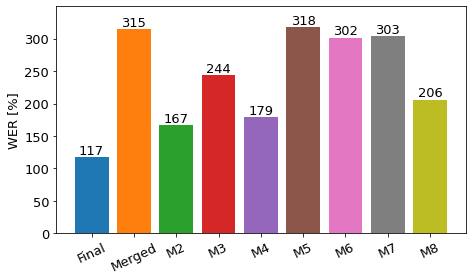

In [85]:
title = "wer_final"
plot_wers(wers, title, skip_final=False)

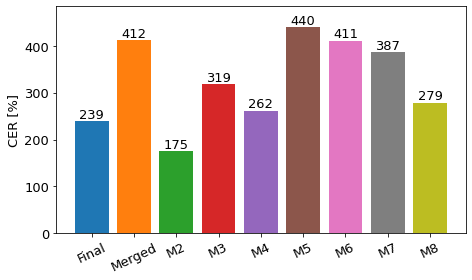

In [86]:
title = "cer_final"
plot_wers(cers, title, skip_final=False)

In [73]:
wers_ohne = wers
wers_ohne.pop("Final")

117.04942822039506

In [89]:
cers_ohne = cers
cers_ohne.pop("Final")

238.9726971033455

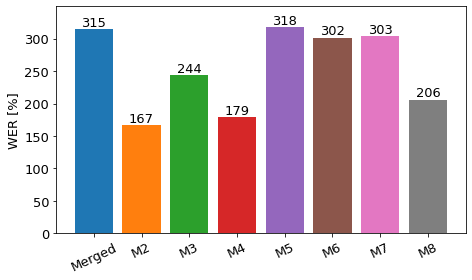

In [87]:
title= "wer"
plot_wers(wers_ohne, title, skip_final=True)

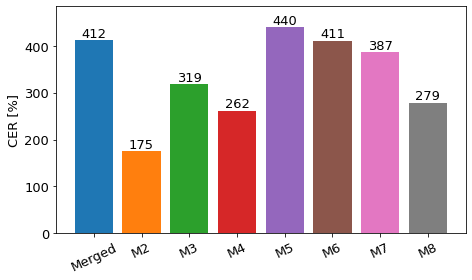

In [88]:
title= "cer"
plot_wers(cers_ohne, title, skip_final=True)

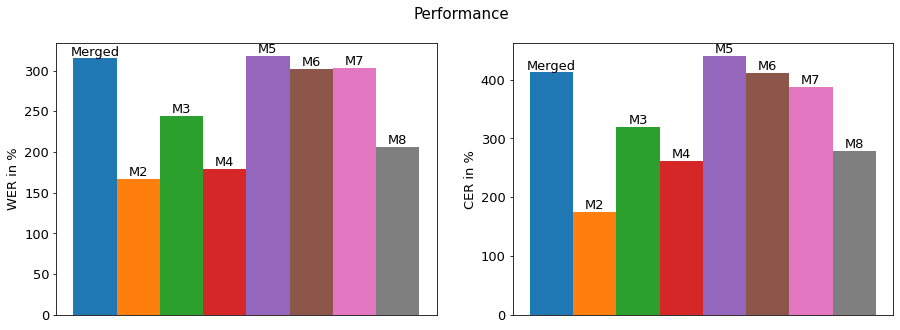

In [107]:
title = "Performance"
plot_wers_cers(wers, cers, title, skip_final=True)

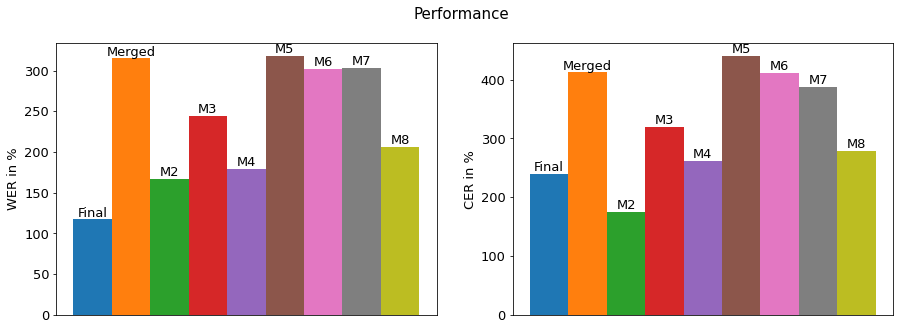

In [108]:
title = "Performance"
plot_wers_cers(wers, cers, title, skip_final=False)

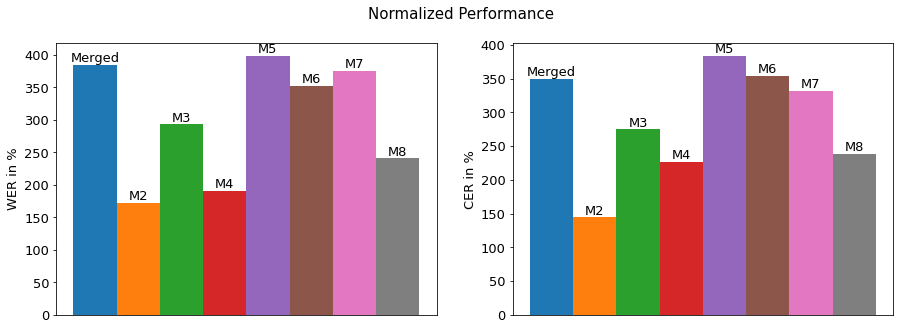

In [109]:
title = "Normalized Performance"
plot_wers_cers(wers_norm, cers_norm, title, skip_final=True)

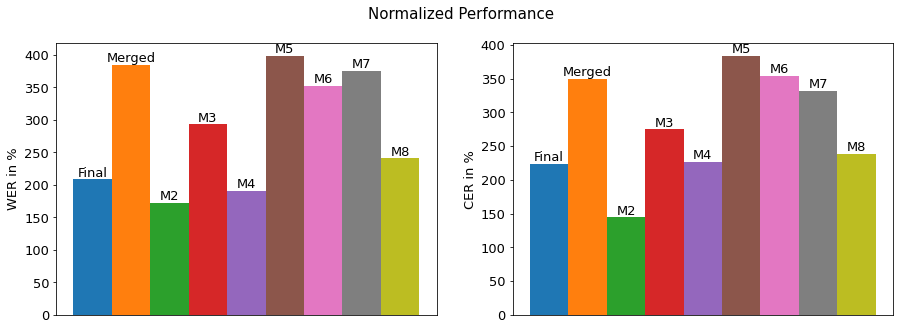

In [110]:
title = "Normalized Performance"
plot_wers_cers(wers_norm, cers_norm, title, skip_final=False)

In [38]:
# exemplary predictions for severities
n_samples = 1000
sevs = ["v_l", "l", "m", "h", "c", "all"]

#transcripts, targets, all_indices = exemplary_preds(sevs,n_samples,ds_severities_merged)
transcripts_um, targets_um, all_indices_um = exemplary_preds(sevs,n_samples,ds_severities)

v_l
l
m
h
c
all


In [33]:
# exemplary predictions
sev = "m"
for i in range(10):
    print(targets[sev][i], " - ", transcripts[sev][i])

Seven  -   Turn.
python  -   Bye, Sam.
look  -   Walk
no  -   No.
or  -   Oh!
homeopath  -   Home we obeyed
now  -   Yeah
long  -   Long!
amethysts  -   and I'm a deceased.
greyhound  -   Very good.


In [16]:
metric_wer = evaluate.load("wer")
metric_cer = evaluate.load("cer")

In [43]:

wers, wers_norm = wers_wersnorm(metric, targets, transcripts, processor, metric_wer)
wers_um, wers_norm_um = wers_wersnorm(metric, targets_um, transcripts_um, processor, metric_wer)

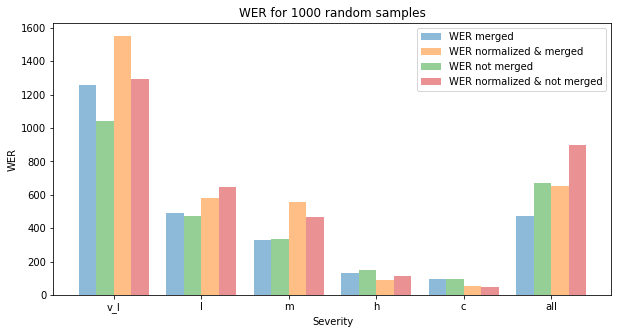

In [48]:
# Number of bar pairs
N = 6
ind = np.arange(N)
width= 0.2
alpha=alpha

plt.figure(figsize=(10,5))
plt.bar(ind, list(wers.values()),  width=width, alpha=alpha, label="WER merged")
plt.bar(ind+2*width, list(wers_norm.values()), width=width, alpha=alpha, label="WER normalized & merged")
plt.bar(ind+width, list(wers_um.values()),  width=width, alpha=alpha, label="WER not merged")
plt.bar(ind+3*width, list(wers_norm_um.values()), width=width, alpha=alpha, label="WER normalized & not merged")

plt.xlabel("Severity")
plt.ylabel("WER")
plt.title(f"WER for {n_samples} random samples")

plt.xticks(ind+3*width/2, sevs)
plt.legend()
plt.show()

**Histogramm of WERs for each word**

In [50]:
def sample_wers(ds, modus, processor, metric):
    samples = ds["all"]+ds["c"]
    labels = ds["transcripts_all"]+ ds["transcripts_c"]
    transcripts = load_pkl(f'datasets/transcripts_{modus}_pt.pkl')


    metrics = []
    metrics_norm = []

    for i in range(len(samples)):
         # normalise
        transcript_norm = processor.tokenizer._normalize(transcripts[i])
        label_norm = processor.tokenizer._normalize(labels[i]) 

        # calculate wer and normalized wer for each sample separately
        m = 100 * metric.compute(references=[labels[i]], predictions=[transcripts[i]])
        metrics.append(m)
        metric_norm = 100 * metric.compute(references=[label_norm], predictions=[transcript_norm])
        metrics_norm.append(metric_norm)
    
    return metrics, metrics_norm

In [51]:
samp_wers = dict()
samp_wers_norm = dict()
samp_cers = dict()
samp_cers_norm = dict()

mics = ["M2", "M3", "M4", "M5", "M6", "M7", "M8"]


samp_wers["Merged"], samp_wers_norm["Merged"] = sample_wers(ds_test, "test", processor, metric_wer)
samp_cers["Merged"], samp_cers_norm["Merged"] = sample_wers(ds_test, "test", processor, metric_cer)

for i,ds in enumerate([ds_M2, ds_M3, ds_M4, ds_M5, ds_M6, ds_M7, ds_M8]):
    samp_wers[mics[i]], samp_wers_norm[mics[i]]= sample_wers(ds, mics[i], processor, metric_wer)
    samp_cers[mics[i]], samp_cers_norm[mics[i]]= sample_wers(ds, mics[i], processor, metric_cer)
    

/project/newvenv/lib/python3.8/site-packages/transformers/models/whisper/tokenization_whisper.py:501: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


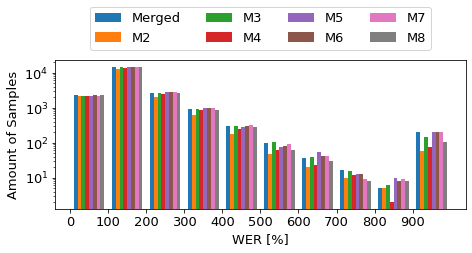

In [101]:
data = []
legend = []
for key in samp_wers:
    data.append(np.array(samp_wers[key]))
    legend.append(key)
test_hist_multi(data, xlabel="WER [%]", ylabel="Amount of Samples", title="wer_sample", legend=legend, log=True, stacked=False,bins="auto",lower=0, upper=1000)

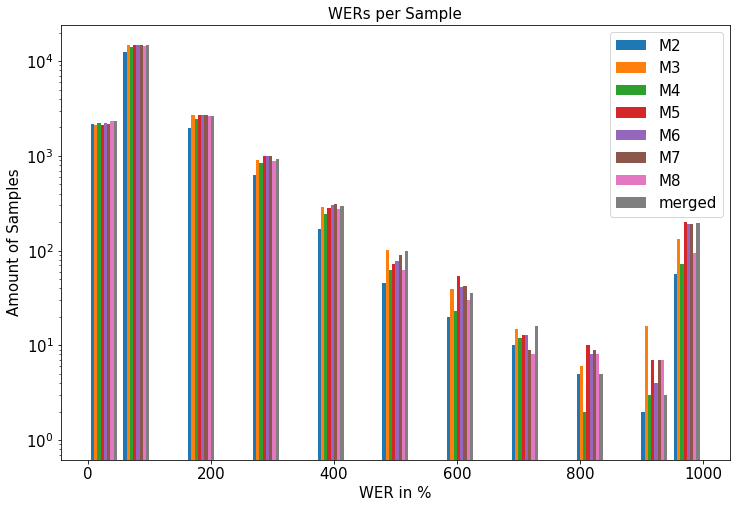

In [164]:
data = []
legend = []
for key in samp_wers:
    data.append(np.array(samp_wers[key]))
    legend.append(key)
test_hist_multi(data, xlabel="WER in %", ylabel="Amount of Samples", title="WERs per Sample", legend=legend, log=True, stacked=False,bins="auto",lower=0, upper=1000)

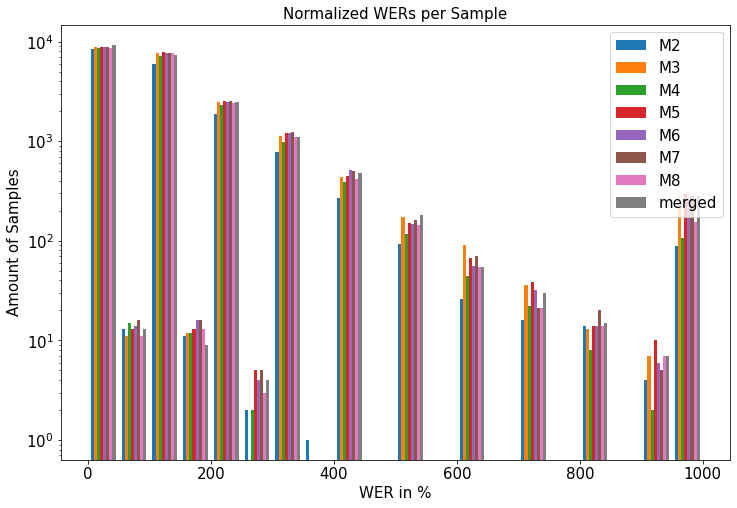

In [165]:
data = []
legend = []
for key in samp_wers_norm:
    data.append(np.array(samp_wers_norm[key]))
    legend.append(key)
test_hist_multi(data, xlabel="WER in %", ylabel="Amount of Samples", title="Normalized WERs per Sample", log=True,legend=legend, stacked=False,bins=20,lower=0, upper=1000)

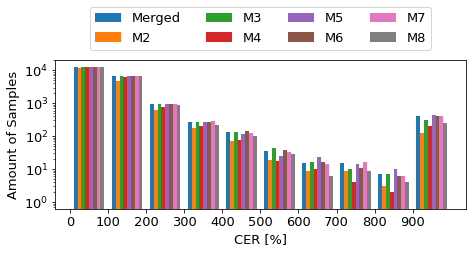

In [102]:
data = []
legend = []
for key in samp_cers:
    data.append(np.array(samp_cers[key]))
    legend.append(key)
#legend =  list(samp_cers.keys())
test_hist_multi(data, xlabel="CER [%]", ylabel="Amount of Samples", title="cer_sample", stacked=False, log=True, legend=legend, bins=20, lower=0, upper=1000)

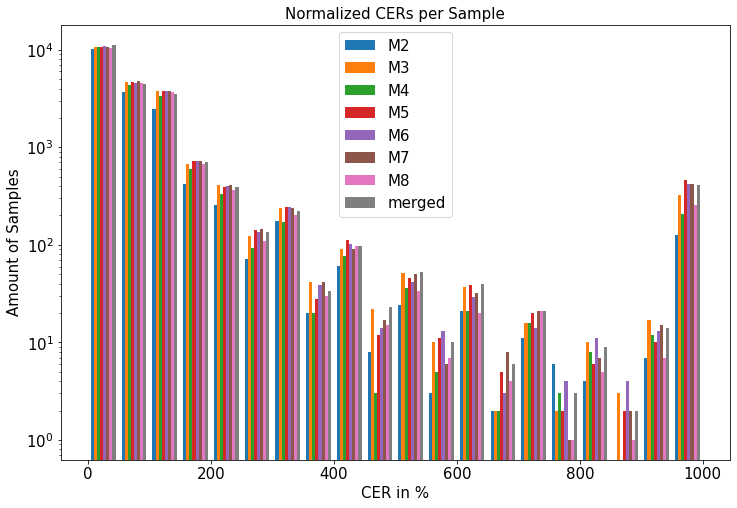

In [167]:
data = []
legend = []
for key in samp_cers_norm:
    data.append(np.array(samp_cers_norm[key]))
    legend.append(key)
test_hist_multi(data, xlabel="CER in %", ylabel="Amount of Samples",title="Normalized CERs per Sample", log=True, bins=20, stacked=False, legend=legend, lower=0, upper=1000)

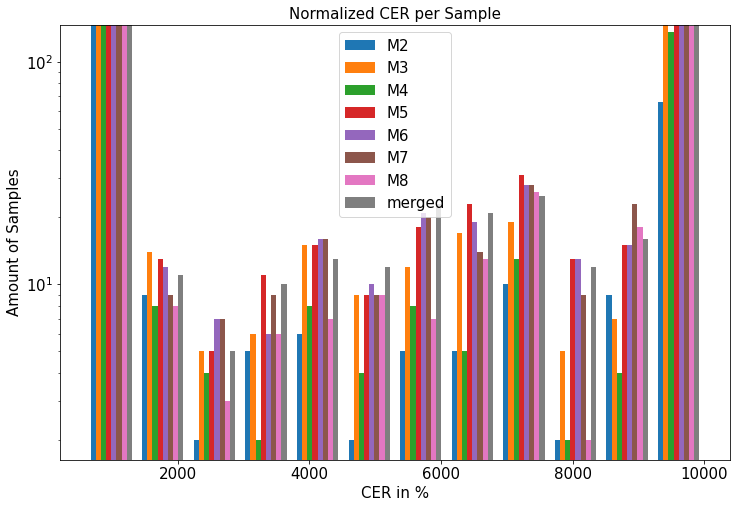

In [168]:
data = []
legend = []
for key in samp_cers_norm:
    data.append(np.array(samp_cers_norm[key]))
    legend.append(key)
test_hist_multi(data, xlabel="CER in %", ylabel="Amount of Samples", title="Normalized CER per Sample", log=True, bins="auto", stacked=False,legend=legend, lower=600, upper=10000)

In [62]:
print("Maximum WER per sample:",np.array(samp_wers["merged"]).max())
print("Maximum normalized WER per sample:",np.array(samp_wers_norm["merged"]).max())
print("Amount of samples with WER higher than 800:",(np.array(samp_wers["merged"]) > 800).sum())
#print("Amount of samples with WER higher than 600:",(np.array(counts_merged["char_count"]) > 100).sum())

Maximum WER per sample: 44400.0
Maximum normalized WER per sample: 44400.0
Amount of samples with WER higher than 800: 197


**TODO**: Remove samples for which WER ist to high

In [174]:
inds = np.argwhere(np.array(wers_merged) > 800).ravel()
paths = find_paths(inds) # -> have to be removed

In [175]:
paths

['M01_B2_D0',
 'M01_B3_D5',
 'M01_B2_LT',
 'M01_B1_LU',
 'M12_B2_LX',
 'M01_B1_LZ',
 'M01_B2_LI',
 'M01_B2_LV',
 'M01_B1_LY',
 'M01_B2_LG',
 'M12_B3_C3',
 'M01_B1_C4',
 'M01_B1_C9',
 'M04_B2_C16',
 'M01_B1_C17',
 'M01_B1_CW2',
 'M01_B1_CW6',
 'M01_B1_CW14',
 'M01_B2_CW16',
 'M01_B2_CW25',
 'M01_B3_CW37',
 'M01_B1_CW39',
 'M01_B1_CW40',
 'M01_B2_CW42',
 'M01_B3_CW50',
 'M01_B2_CW52',
 'M01_B3_CW52',
 'M04_B3_CW52',
 'M01_B3_CW55',
 'M01_B3_CW56',
 'M01_B2_CW57',
 'M01_B3_CW57',
 'M01_B1_CW59',
 'M12_B1_CW68',
 'M01_B3_CW74',
 'M01_B1_CW80',
 'M01_B2_CW80',
 'M01_B2_CW83',
 'M01_B3_CW87',
 'M01_B1_CW88',
 'M01_B2_CW88',
 'M01_B3_CW88',
 'M04_B3_CW88',
 'M01_B3_CW90',
 'M01_B1_CW91',
 'M01_B2_CW91',
 'M01_B3_CW95',
 'M01_B2_CW99',
 'M01_B1_UW3',
 'F03_B1_UW4',
 'M01_B1_UW5',
 'M01_B1_UW13',
 'F03_B1_UW14',
 'F03_B1_UW16',
 'M01_B1_UW18',
 'M12_B1_UW18',
 'M04_B1_UW21',
 'F03_B1_UW23',
 'M01_B1_UW27',
 'M01_B1_UW31',
 'M01_B1_UW34',
 'M01_B1_UW35',
 'M01_B1_UW38',
 'M01_B1_UW41',
 'F03_B1_

### Some Exemplary Predictions

In [338]:
modus = "final"
ds= load_pkl(f'datasets/{modus}.pkl')

labels = ds["transcripts_all"]+ ds["transcripts_c"]
transcripts = load_pkl(f'datasets/transcripts_{modus}_pt.pkl')

In [339]:
# exemplary predictions
n_samples = 50
indices = np.random.randint(len(labels),size=n_samples)
for i in indices:
    print(labels[i], " - ", transcripts[i])

supervision  -   Supervision
India  -   India.
them  -   Damn!
thine  -   Hey!
had  -   Head
water  -   Water
as  -   As
all  -   Oh.
baths  -   Baaah!
booth  -   booth
hallelujah  -   Hallelujah!
Left  -   Nooo!
durable  -   Durable.
coil  -   Fuuuuh!
Zulu  -   Liiiage!
all  -   All?
some  -   So...
Bravo  -   Bravo!
it  -   It...
rendezvous  -   Ron Devoo.
cup  -   Come on!
re-united  -   We knighted.
these  -   Yeah!
from  -   One
that  -   That...
footmarks  -   Footmarks
day  -   and
way  -   Where is it?
it  -   Hit!
look  -   Look!
what  -   What?
baths  -   Yeah. Yeah. Yeah.
the  -   Yeah?
roly-poly  -   Rollie pulley.
inexhaustible  -   And in the ass too cold.
Echo  -   and go.
Juliet  -   Julia
butcher  -   Why?
hypothesis  -   Hypothesis
beleaguering  -   Deliguring.
what  -   What?
by  -   Yeah, that's good.
a  -   Ah!
when  -   When?
blithe  -   Twice
Uniform  -   uniform
Three  -   Three.
gigantic  -   gigantic
Quebec  -   Go back.
could  -   RUDE!


In [380]:
zipped = list(zip(ds["transcripts_all"]+ds["transcripts_c"],ds["speakers_all"]+ds["speakers_c"]))

In [402]:
ind = zipped.index(('frugality', 'CM04'))
transcripts[ind]

' frugality'

### Exemplary Audio Samples

In [13]:
# sampling rate & batch size
sr = 16000
batch_size=64

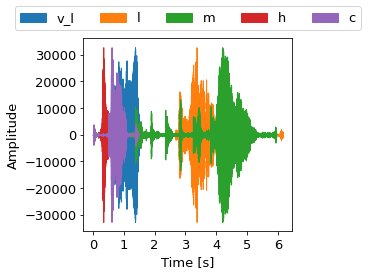

In [8]:
# waveforms for severities very low, low, middle, high. Word: crayon
sr=16000
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure().set_figwidth(480*px)
librosa.display.waveshow(np.float32(ds_crayon["v_l"][0]), sr=sr, label="v_l")
librosa.display.waveshow(np.float32(ds_crayon["l"][0]), sr=sr, label="l")
librosa.display.waveshow(np.float32(ds_crayon["m"][0]), sr=sr, label="m")
librosa.display.waveshow(np.float32(ds_crayon["h"][0]), sr=sr, label="h")
librosa.display.waveshow(np.float32(ds_crayon["c"][0]), sr=sr, label="c")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Amplitude", fontsize=13)
plt.xlabel("Time [s]", fontsize=13)

plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=5)
plt.tight_layout()
plt.savefig("figs/wavs.pdf")
plt.show()

In [54]:
# Play audio samples for word crayon
IPython.display.Audio(np.array(ds_crayon["v_l"][0]), rate=16000)

In [55]:
IPython.display.Audio(np.array(ds_crayon["l"][0]), rate=16000)

In [56]:
IPython.display.Audio(np.array(ds_crayon["m"][0]), rate=16000)

In [57]:
IPython.display.Audio(np.array(ds_crayon["h"][0]), rate=16000)

In [45]:
IPython.display.Audio(np.array(ds_crayon["c"][0]), rate=16000)

## Effects of Normalization

In [65]:
do_normalize = False
sr=16000
inputs = feature_extractor(ds_crayon["all"],do_normalize=do_normalize,sampling_rate=sr,return_tensors="pt").input_features
do_normalize = True
inputs_normalized = feature_extractor(ds_crayon["all"],do_normalize=do_normalize,sampling_rate=sr,return_tensors="pt").input_features

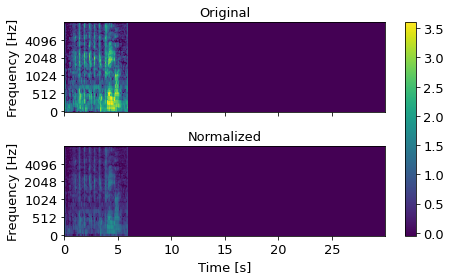

In [67]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_figwidth(480*px)

img1 = librosa.display.specshow(inputs[3].numpy(), cmap=None,x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr, ax=ax[0], vmax=3.6)
ax[0].set_title("Original", fontsize=13)
#ax[0].set_xticks( fontsize=13)
ax[0].set_ylabel("Frequency [Hz]", fontsize=13)
ax[0].xaxis.set_tick_params(labelsize=13)
ax[0].yaxis.set_tick_params(labelsize=13)


img2 = librosa.display.specshow(inputs_normalized[3].numpy(),cmap=None, x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr, ax=ax[1],vmax=3.6)
ax[1].set_title("Normalized", fontsize=13)
ax[1].set_xlabel("Time [s]", fontsize=13)
ax[1].set_ylabel("Frequency [Hz]", fontsize=13)
ax[1].xaxis.set_tick_params(labelsize=13)
ax[1].yaxis.set_tick_params(labelsize=13)

for ax_i in ax:
    ax_i.label_outer()
    
plt.tight_layout()
cbar = fig.colorbar(img2, ax=[ax[0],ax[1]])
cbar.ax.tick_params(labelsize=13)

plt.savefig("figs/normalized.pdf")
plt.show()

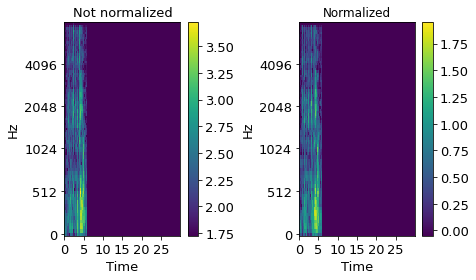

In [37]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure().set_figwidth(480*px)
for i in range(1):
    ax1 = plt.subplot(1,2,1)
    librosa.display.specshow(inputs[3].numpy(), cmap=None,x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr)
    plt.title("Not normalized", fontsize=13)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Time", fontsize=13)
    plt.ylabel("Hz", fontsize=13)
    ax2 = plt.subplot(1,2,i+2)
    librosa.display.specshow(inputs_normalized[3].numpy(),cmap=None, x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr)
    plt.title("Normalized")
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Time", fontsize=13)
    plt.ylabel("Hz", fontsize=13)
    ax1.sharey(ax2)
#plt.suptitle("Comparison of normalized and not normalized input features")
plt.tight_layout()
plt.savefig("figs/normalized.pdf")
#fig.colorbar(not_norm, ax=[ax1,ax2])

plt.show()

## Effects of Trimming

In [59]:
# load data sample from ua speech
ind = np.random.randint(len(ds_severities['all']))
sample = ds_severities["all"][298]
sr = 16000

In [60]:
ds_severities["transcripts_all"].index("crayon")

298

In [61]:
# apply trimming
trimmed = librosa.effects.trim(np.float32(sample), top_db=30)

In [62]:
# 0.2 secs -> 3200 values (16khz)
trimmed = sample[trimmed[1][0]-3200: trimmed[1][1]+3200]

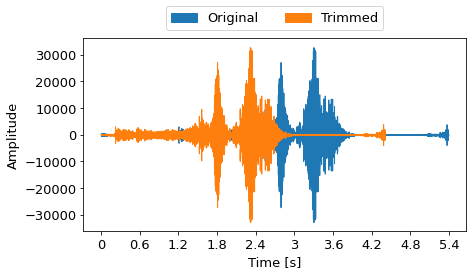

In [63]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure().set_figwidth(480*px)

librosa.display.waveshow(np.float32(sample), sr=sr, label="Original")
librosa.display.waveshow(np.float32(trimmed), sr=sr, label="Trimmed")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Amplitude", fontsize=13)
plt.xlabel("Time [s]", fontsize=13)

plt.legend(fontsize=13,loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.tight_layout()
plt.savefig("figs/trimmed_wav.pdf")
plt.show()

In [335]:
# listen to OG sample
IPython.display.Audio(sample, rate=sr)

In [336]:
# listen to trimmed sample
IPython.display.Audio(trimmed, rate=sr)

In [30]:
do_normalize = True
inputs = feature_extractor(sample, do_normalize=do_normalize,sampling_rate=sr,return_tensors="pt").input_features
inputs_trimmed = feature_extractor(trimmed, do_normalize=do_normalize,sampling_rate=sr,return_tensors="pt").input_features

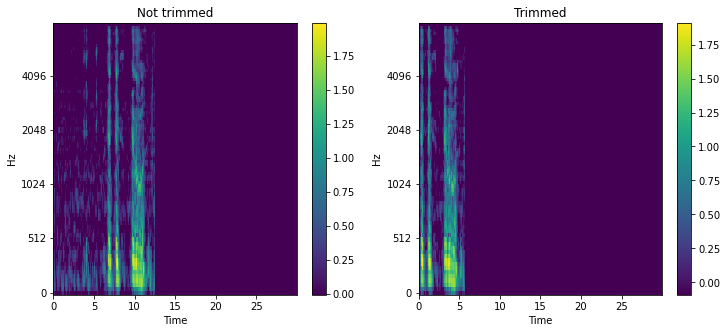

In [31]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
librosa.display.specshow(inputs[0].numpy(), cmap=None, x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr)
plt.title("Not trimmed")
plt.colorbar()
ax2 = plt.subplot(1,2,2)
librosa.display.specshow(inputs_trimmed[0].numpy(), cmap=None, x_axis="time", hop_length=feature_extractor.hop_length, y_axis="mel", sr=sr)
ax2.sharey(ax1)
plt.title("Trimmed")
plt.colorbar()
plt.show()

In [36]:
# comparison of average audio len
#og_len = ds_audio_len(ua_all, sr, True)
trimmed_len = ds_audio_len(ds_severities["all"], sr, False, False)

In [100]:
print(f"Average audio length before trimming: {og_len} seconds")
print(f"Average audio length after trimming: {trimmed_len} seconds")

Average audio length before trimming: 3.175688014214548 seconds
Average audio length after trimming: 1.0686737613660424 seconds
